# PDAC ILP (Exact) Algorithm analysis
This notebook is used to analyze the performance of the ILP (exact) job scheduling algorithm. Specifically, it uses an relaxed ILP (inexact) scheduling algorithm, greedy heuristic scheduling algorithm and a naive scheduling algorithm for comparison. The peak demand above the curve (PDAC) is measured across five different trials for each specified job batch size and then plotted on a graph. 

In [6]:
import sys
import os
import random
import json
import matplotlib.pyplot as plt
import numpy as np
import time

# Add the parent directory of AAC/ to sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

Import the ILP (exact), relaxed ILP (inexact), greedy and naive algorithms from their respective files in the repository

In [7]:
from PDAC.pdac_scheduling_ilp import solve_pdac_ilp
from PDAC.pdac_scheduling_lp import solve_pdac_lp
from PDAC.pdac_scheduling_greedy import solve_pdac_greedy
from PDAC.pdac_scheduling_naive import solve_pdac_naive

# Program Parameters
In the code below, you can specify the start time, end time and maximum length of each job in each batch of jobs. \
\
&emsp;&emsp; - 0 denotes 12am and 1400 denotes 12am of the following day. \
&emsp;&emsp; - Therefore, one day contains exactly 1440 minutes of job data
\
\
Additionally, you can specify the sizes of each job batch that is analyzed in this program. \
\
&emsp;&emsp; - The start size is the smallest batch size to be analyzed \
&emsp;&emsp; - The end size is the largest batch size (exclusive) to be analyzed \
&emsp;&emsp; - The step size is how much the job batch increases per analytical trial
\
\
For the exact algorithm, because it is an ILP, runtime increases exponentially as the job batch sizes increase. It is therefore advisable to keep the job batch sizes at or below 100 for this analysis

In [8]:
start_time = 0
end_time = 1400
max_length = 700

start_size = 10
end_size = 100
step_size = 10

analysis_num = 0

# Resource Curve
The resource curve is represented by a list of values across the specified time period. Where at a given time t there will be exactly resources[t] amount of power available to the jobs. The data for these resources is available in the Input_Data folder. 
\
\
Additionally, each height is multiplied by a scaling factor. This is so that the resource curve better fits the job curve. Otherwise, the resource curve would be too large for any sort of significant analysis. This scaling factor remains constant for each of the trials and for every job batch size for the sake of consistency. 

In [9]:
# Instantiate the resource curve
path = '../../Input_Data/solar_data.json'
with open(path, 'r') as file:
    data = json.load(file)

wind_energy = data['series'][1]['data']
solar_energy = data['series'][2]['data']
hydro_energy = data['series'][3]['data']

# Have 165 hours and you want minute by minute resolution. Therefore the total length of this list needs to be 165 * 60 in length
# The first 60 values of the list need to equal 0, the next need to equal 1. Therefore, i // 60
wind_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(wind_energy_7_days)):
    wind_energy_7_days[i] = wind_energy[ i // 60 ]['value']

solar_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(solar_energy_7_days)):
    solar_energy_7_days[i] = solar_energy[ i // 60 ]['value']

hydro_energy_7_days = [0 for _ in range(165 * 60)]
for i in range(len(hydro_energy_7_days)):
    hydro_energy_7_days[i] = hydro_energy[ i // 60 ]['value']


total = []
for i in range(165 * 60):
    total_sum = wind_energy_7_days[i] + solar_energy_7_days[i] + hydro_energy_7_days[i]
    total.append(total_sum)

day = 3
resources = total[(24 * day) + start_time : (24 * day) + end_time]

# # Implement a resource curve scaling factor to better fit the jobs
scale_factor = 0.05
resources = [r * scale_factor for r in resources]

# Algorithm Analysis
For each batch size, there will be five trials run on each algorithm. Each time, a random assortment of jobs will be provided to the algorithms. However, these jobs will be the same for each algorithm, so they will be tested on the same jobs. This is for the most accurate possible comparisons. 
\
\
Additionally, the time it takes for each algorihtm to run is measured. 

In [10]:
# This is The list of job objects that will be scheduled
# They each have a release, deadline, duration and height
path = '../../Input_Data/job_data.json'
with open(path, 'r') as file:
    data = json.load(file)

# Randomly shuffle the jobs so that there is variation between trials
jobs_array = data['jobs']

pdac_inexact = []
pdac_exact = []
pdac_greedy = []
pdac_naive = []

final_data = []

for batch_size in range(start_size, end_size, step_size):
    exact_total = 0
    inexact_total = 0
    greedy_total = 0
    naive_total = 0
    
    print(f"\nBatch Size: {batch_size}")

    for trial in range(5):
        print(f"Trial #: {trial}")
        random.shuffle(jobs_array)
        
        start = time.time()
        exact = solve_pdac_ilp(jobs_array, resources, start_time, end_time, max_length, batch_size)[0]
        exact_total += exact
        end = time.time()
        exact_time = end - start
        print(f"Exact Objective: {exact}, Elapsed Time: {exact_time}")

        start = time.time()
        inexact = solve_pdac_lp(jobs_array, resources, start_time, end_time, max_length, batch_size)[0]
        inexact_total += inexact
        end = time.time()
        inexact_time = end - start
        print(f"Inexact Objective: {inexact}, Elapsed Time: {inexact_time}")

        start = time.time()
        greedy = solve_pdac_greedy(jobs_array, resources, start_time, end_time, max_length, batch_size)[0]
        greedy_total += greedy
        end = time.time()
        greedy_time = end - start
        print(f"Greedy Objective: {greedy}, Elapsed Time: {greedy_time}")

        start = time.time()
        naive = solve_pdac_naive(jobs_array, resources, start_time, end_time, max_length, batch_size)[0]
        naive_total += naive
        end = time.time()
        naive_time = end - start
        print(f"Naive Objective: {naive}, Elapsed Time: {naive_time}")

        trial_data = {
            "batch size": batch_size, 
            "trial #": trial,
            "exact objective val": exact, 
            "exact time": exact_time, 
            "naive obective val": naive, 
            "naive time": naive_time, 
            "inexact objective val": inexact, 
            "inexact time": inexact_time, 
            "greedy objective val": greedy, 
            "greedy time": greedy_time
        }
        final_data.append(trial_data)

    pdac_inexact.append(inexact_total / 5)
    pdac_exact.append(exact_total / 5)
    pdac_greedy.append(greedy_total / 5)
    pdac_naive.append(naive_total / 5)



Batch Size: 10
Trial #: 0
Exact Objective: 3639.5200000000004, Elapsed Time: 0.20596599578857422
Inexact Objective: 4455.47, Elapsed Time: 0.05874300003051758
Greedy Objective: 5065.570000000001, Elapsed Time: 0.0038559436798095703
Naive Objective: 5099.02, Elapsed Time: 0.00013899803161621094
Trial #: 1
Exact Objective: 1235.5600000000002, Elapsed Time: 0.1994459629058838
Inexact Objective: 1235.56, Elapsed Time: 0.1029367446899414
Greedy Objective: 1235.56, Elapsed Time: 0.007953166961669922
Naive Objective: 1250.66, Elapsed Time: 0.00014019012451171875
Trial #: 2
Exact Objective: 689.5100000000002, Elapsed Time: 0.15317010879516602
Inexact Objective: 902.6399999999999, Elapsed Time: 0.04769015312194824
Greedy Objective: 1035.69, Elapsed Time: 0.0021970272064208984
Naive Objective: 759.3100000000001, Elapsed Time: 0.00011014938354492188
Trial #: 3
Exact Objective: 954.7999999999998, Elapsed Time: 0.1579129695892334
Inexact Objective: 1625.7299999999998, Elapsed Time: 0.0518059730529

[{'batch size': 10, 'trial #': 0, 'exact objective val': 3639.5200000000004, 'exact time': 0.20596599578857422, 'naive obective val': 5099.02, 'naive time': 0.00013899803161621094, 'inexact objective val': 4455.47, 'inexact time': 0.05874300003051758, 'greedy objective val': 5065.570000000001, 'greedy time': 0.0038559436798095703}, {'batch size': 10, 'trial #': 1, 'exact objective val': 1235.5600000000002, 'exact time': 0.1994459629058838, 'naive obective val': 1250.66, 'naive time': 0.00014019012451171875, 'inexact objective val': 1235.56, 'inexact time': 0.1029367446899414, 'greedy objective val': 1235.56, 'greedy time': 0.007953166961669922}, {'batch size': 10, 'trial #': 2, 'exact objective val': 689.5100000000002, 'exact time': 0.15317010879516602, 'naive obective val': 759.3100000000001, 'naive time': 0.00011014938354492188, 'inexact objective val': 902.6399999999999, 'inexact time': 0.04769015312194824, 'greedy objective val': 1035.69, 'greedy time': 0.0021970272064208984}, {'ba

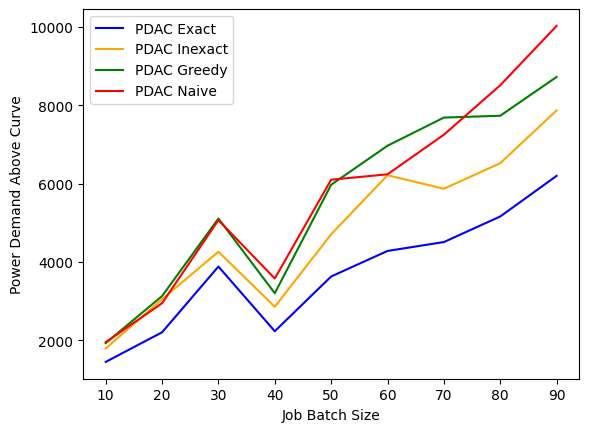

In [11]:
print(final_data)
job_graph_xvalues = np.array([i for i in range(start_size, end_size, step_size)])

plt.plot(job_graph_xvalues, pdac_exact, label="PDAC Exact", color='blue')
plt.plot(job_graph_xvalues, pdac_inexact, label="PDAC Inexact", color='orange')
plt.plot(job_graph_xvalues, pdac_greedy, label="PDAC Greedy", color='green')
plt.plot(job_graph_xvalues, pdac_naive, label="PDAC Naive", color='red')


plt.xlabel("Job Batch Size")
plt.ylabel("Power Demand Above Curve")
plt.legend()
plt.show()

In [12]:
import csv
# Write to a data csv file
with open(f"../../Output_Data/PDAC_Results/exact_pdac_analysis_{analysis_num}.csv", "a", newline="") as csvfile:
    fieldnames = ['batch size', 'trial #', 'exact objective val', 'exact time', 'naive obective val', 'naive time', 'inexact objective val', 'inexact time', 'greedy objective val', 'greedy time']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Only write the header on the very first trial run
    writer.writeheader()
    writer.writerows(final_data)

    csvfile.close()